In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import cv2, glob, random
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
input_shape = (128, 128, 3)

In [3]:
DATA_DIR = "/content/drive/My Drive/final_cropped/"
X = []
Y = []
k = 0
for i in range(2190):
  X.append(f"/content/drive/My Drive/final_cropped/{i+1}.jpg")
  if i % 6 == 0:
    k += 1
  Y.append(k)

In [4]:
(x_train, y_train), (x_test, y_test) = (X[:int(0.8*len(X))], Y[:int(0.8*len(Y))]), (X[int(0.8*len(X)):], Y[int(0.8*len(Y)):])
y_train = np.array(y_train)
y_test = np.array(y_test)


In [5]:
def plot_pairs(examples):
  for i in range(2):
    plt.subplot(1, 3, 1 + i)
    plt.imshow(np.reshape(examples[i], (128, 128, 3)), cmap='binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()

In [6]:
emb_size = 64
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, traindir, labels, batch_size=32):
    self.traindir = traindir
    self.labels = labels
    self.batch_size = batch_size

  def __len__(self):
    return int(np.floor(len(self.traindir) / self.batch_size))

  def __getitem__(self, index):
    while True:
        x1, x2, y = self.create_pairs()
        return [x1, x2], y

  def create_pairs(self):
    X1 = []
    X2 = []
    labels = []
    for i in range(self.batch_size):
      random_index = random.randint(0, len(self.traindir) - 1)

      #Anchor image
      x_anchor = cv2.resize(cv2.imread(self.traindir[random_index]), (128, 128))
      # x_anchor = np.expand_dims(x_anchor, axis=2)
      x_anchor = x_anchor.astype('float32')
      x_anchor /= 255.

      y = self.labels[random_index]
      indices_for_pos = np.squeeze(np.where(self.labels == y))
      indices_for_neg = np.squeeze(np.where(self.labels != y))
      
      #Positive image
      x_positive = cv2.resize(cv2.imread(self.traindir[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]), (128, 128))
      # x_positive = np.expand_dims(x_positive, axis=2)
      x_positive = x_positive.astype('float32')
      x_positive /= 255.

      #Negative image
      x_negative = cv2.resize(cv2.imread(self.traindir[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]), (128, 128))
      # x_negative = np.expand_dims(x_negative, axis=2)
      x_negative = x_negative.astype('float32')
      x_negative /= 255.

      X1.append(x_anchor)
      X2.append(x_positive)
      labels.append(1)

      X1.append(x_anchor)
      X2.append(x_negative)
      labels.append(0)


    return np.array(X1), np.array(X2), np.array(labels)

  

In [7]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
  margin = 1
  square_pred = K.square(y_pred)
  margin_square = K.square(K.maximum(margin - y_pred, 0))
  return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


In [8]:
def embedding_model():
  # model = tf.keras.models.Sequential([
  #   tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
  #   tf.keras.layers.MaxPooling2D(2, 2),
  #   tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  #   tf.keras.layers.MaxPooling2D(2, 2),
  #   tf.keras.layers.Flatten(input_shape = input_shape),
  #   tf.keras.layers.Dense(64, activation='relu'),
  #   tf.keras.layers.Dropout(0.4),
  #   tf.keras.layers.Dense(emb_size, activation='relu')                                            
  # ])
  resnet = tf.keras.applications.ResNet50(include_top = False, weights='imagenet', input_shape=input_shape)
  for layer in resnet.layers:
    layer.trainable = False
  resnet.summary()
  x = resnet.get_layer('conv5_block3_out').output
  model_out = tf.keras.layers.Flatten()(x)
  model_out = tf.keras.layers.Dense(emb_size, activation='relu')(model_out)
  model = tf.keras.models.Model(inputs=resnet.input, outputs=model_out)
  return model

In [9]:
def complete_network(base_model):
  input_a = tf.keras.layers.Input(shape=input_shape)
  input_b = tf.keras.layers.Input(shape=input_shape)

  embedding_a = base_model(input_a)
  embedding_b = base_model(input_b)

  distance = tf.keras.layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([embedding_a, embedding_b])

  model = tf.keras.models.Model([input_a, input_b], distance)

  return model

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
__________________________

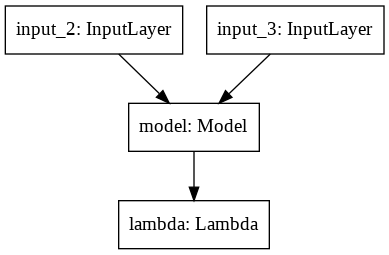

In [10]:
batch_size = 32

train_generator = DataGenerator(x_train, y_train, batch_size)
test_generator = DataGenerator(x_test, y_test, batch_size)

base_model = embedding_model()
model = complete_network(base_model)
model.compile(loss=contrastive_loss, optimizer='adam', metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png')

In [11]:
train_generator = DataGenerator(x_train, y_train, batch_size)
test_generator = DataGenerator(x_test, y_test, batch_size)

In [12]:
epochs = 50
steps_per_epoch=20
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=10
)

Epoch 1/50
20/20 [==============================] - 405s 20s/step - loss: 0.2388 - accuracy: 0.4148 - val_loss: 0.2145 - val_accuracy: 0.3578
Epoch 2/50
20/20 [==============================] - 120s 6s/step - loss: 0.2033 - accuracy: 0.3359 - val_loss: 0.1894 - val_accuracy: 0.2891
Epoch 3/50
20/20 [==============================] - 51s 3s/step - loss: 0.1954 - accuracy: 0.2961 - val_loss: 0.1878 - val_accuracy: 0.3172
Epoch 4/50
20/20 [==============================] - 31s 2s/step - loss: 0.1895 - accuracy: 0.2922 - val_loss: 0.1817 - val_accuracy: 0.2797
Epoch 5/50
20/20 [==============================] - 22s 1s/step - loss: 0.1782 - accuracy: 0.2711 - val_loss: 0.1727 - val_accuracy: 0.2750
Epoch 6/50
20/20 [==============================] - 19s 960ms/step - loss: 0.1818 - accuracy: 0.3008 - val_loss: 0.1755 - val_accuracy: 0.2688
Epoch 7/50
20/20 [==============================] - 21s 1s/step - loss: 0.1701 - accuracy: 0.2625 - val_loss: 0.1705 - val_accuracy: 0.2766
Epoch 8/50
20/

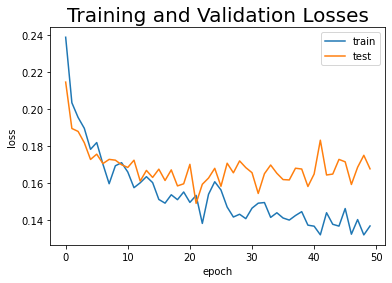

In [13]:
#plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(f"/content/drive/My Drive/Contrastive loss png")
plt.show()